<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite Volume Method - 1D Advection Equation</div>
        </div>
    </div>
</div>

<p style="width:20%;float:right;padding-left:50px">
<img src=../../share/images/book.jpg>
<span style="font-size:smaller">
</span>
</p>


---

This notebook is part of the supplementary material 
to [Computational Seismology: A Practical Introduction](https://global.oup.com/academic/product/computational-seismology-9780198717416?cc=de&lang=en&#), 
Oxford University Press, 2016.


##### Authors:
* David Vargas ([@dvargas](https://github.com/davofis))
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))

## Basic Equations
We want to solve the linear advection equation as a scalar hyperbolic equation:

\begin{equation}
\partial_t q + a \partial_x q = 0
\end{equation}

This equation arises from conservation principles considering the case of advective fluxes. Let us partitioned the space in $n$ cells centered at $x = x_i$, the average of the quantity $q$ inside the cell is 

\begin{equation}
Q_{i}^{n} = \int_{\mathscr{c}} q(x,t) dx
\end{equation}

Any change inside each cell implies a net flux through the cell boundaries, then

\begin{equation}
\frac{Q_{i}^{n+1} - Q_{i}^{n}}{dt} = \frac{F_{i-1/2}^{n} - F_{i+1/2}^{n}}{dx}
\end{equation}

in an advection problem, the flux terms simply are

\begin{equation}
F_{i-1/2}^{n} =  a Q_{i-1}^{n}
\qquad\text{and}\qquad
F_{i+1/2}^{n} =  a Q_{i}^{n}
\end{equation}

Using the above definitions we obtain a complete discrete extrapolation scheme as

\begin{equation}
Q_{i}^{n+1}  = Q_{i}^{n} + a \frac{dt}{dx}(Q_{i-1}^{n} - Q_{i}^{n})
\end{equation}

This is the so call upwind scheme. Alternatively, one uses the Taylor expansion to extrapolate $Q(x, t)$ in time. Successive differentiation of the advection equation allows us to express time derivatives in terms of space derivatives. Finally, finite differences are used to approximate space derivatives leading to the Lax-Wendroff Scheme.

\begin{equation}
Q_{i}^{n+1}  = Q_{i}^{n} - \frac{adt}{2dx}(Q_{i+1}^{n} - Q_{i-1}^{n}) + \frac{1}{2}(\frac{adt}{dx})^2(Q_{i+1}^{n} - 2Q_{i}^{n} + Q_{i-1}^{n})
\end{equation} 


This notebook implements both upwind and Lax-Wendroff schemes for solving the scalar advection equation. To keep the problem simple we use as spatial initial condition a Gauss function with half-width $\sigma$

\begin{equation}
Q(x,t=0)  = e^{-1/\sigma^2 (x - x_{o})^2}
\end{equation}


In [1]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation


### 1. Initialization of setup

In [2]:
# Initialization of setup
# --------------------------------------------------------------------------
nx     = 2000       # number of grid points
xmax   = 8000       # in m
c      = 2500       # Advected speed
eps    = 0.5        # CFL
tmax   = 2          # simulation time in s
sig    = 200        # Gaussian width, in m
x0     = 1000       # Gaussian position, in m
method = 'Lax-Wendroff'   # 'Lax-Wendroff', 'upwind'
isnap  = 10 

### 2. Finite Volumes setup

In [3]:
# Initialize Space
x  = np.linspace(0,xmax,nx)
dx = min(np.diff(x))

# use wave based CFL criterion
dt = eps*dx/c    # calculate tim step from stability criterion

# Simulation time
nt = int(np.floor(tmax/dt))

# Initialize shape of fields
Q   = np.zeros(nx)
dQ  = np.zeros(nx)
dQ1 = np.zeros(nx)
dQ2 = np.zeros(nx)
Qa  = np.zeros(nx)

### 3. Initial condition

<IPython.core.display.Javascript object>


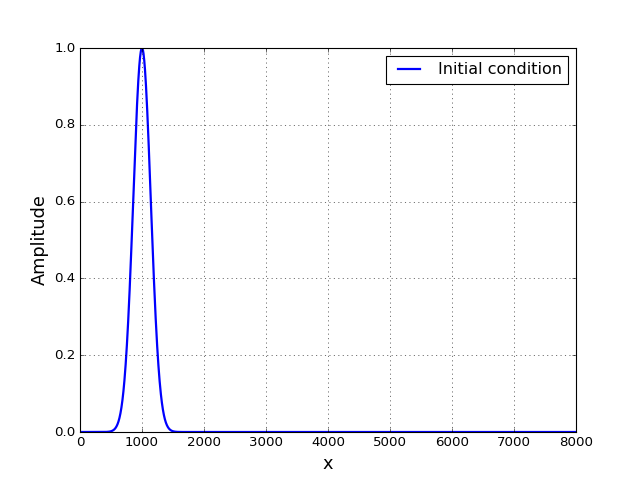

In [4]:
# Spatial initial condition
#---------------------------------------------------------------
sx = np.exp(-1./sig**2 * (x-x0)**2)

# Set Initial condition 
Q = sx

# ---------------------------------------------------------------
# Plot initial condition
# ---------------------------------------------------------------
plt.plot(x, sx, color='b', lw=2, label='Initial condition')
plt.ylabel('Amplitude', size=16)
plt.xlabel('x', size=16)
plt.legend()
plt.grid(True)
plt.show()

### 4. Solution for the scalar advection problem

<IPython.core.display.Javascript object>


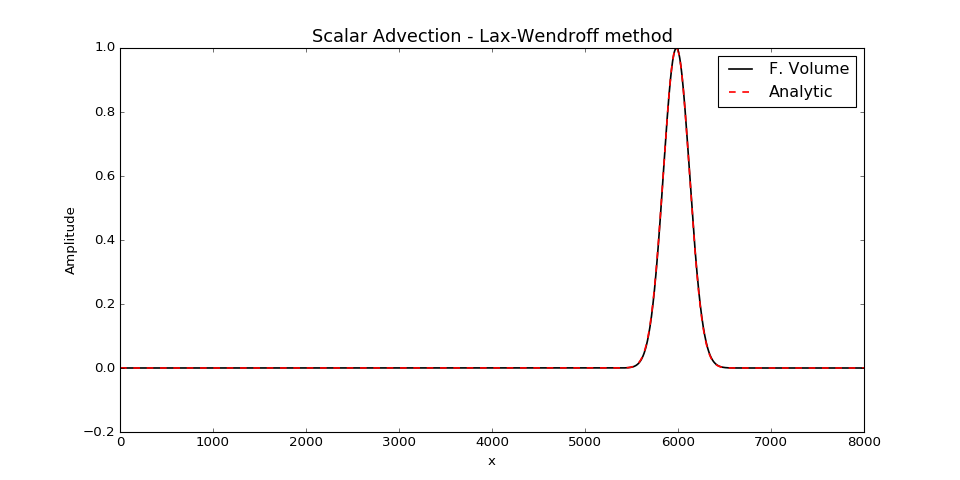

In [5]:
# ---------------------------------------------------------------
# Initialize animated plot
# ---------------------------------------------------------------
fig = plt.figure(figsize=(12,6))
line = plt.plot(x, Q, 'k', x, Qa, 'r--')
plt.ylabel('Amplitude')
plt.xlabel('x')
plt.title('Scalar Advection - %s method'%method, size=16)

plt.ion()    # set interective mode
plt.show()

# ---------------------------------------------------------------
# Time extrapolation
# --------------------------------------------------------------- 
for i in range(nt): 
    # upwind method
    if method == 'upwind': 
        for j in range(1, nx-1):
            # Forward (upwind) (c>0)
            dQ[j] = Q[j] - Q[j-1]
        # Time extrapolation 
        Q = Q - dt/dx*c*dQ
        
    # Lax wendroff method
    if method == 'Lax-Wendroff': 
        for j in range(1, nx-1):
            # Forward (upwind) (c>0)
            dQ1[j] = Q[j+1] - 2*Q[j] + Q[j-1]
            dQ2[j] = Q[j+1] - Q[j-1]
        # Time extrapolation 
        Q = Q - 0.5*c*dt/dx*dQ2 + 0.5*(c*dt/dx)**2 *dQ1
        
    # Boundary condition     
    Q[0] = Q[nx-2]    # Periodic    
    Q[nx-1] = Q[nx-2] # Absorbing
    
    # --------------------------------------   
    # Animation plot. Display solution
    if not i % isnap: 
        for l in line:
            l.remove()
            del l  
        # -------------------------------------- 
        # Analytical solution
        xd = c*i*dt+x0
        Qa = np.exp(-1./sig**2 * (x - xd)**2)
        
        # -------------------------------------- 
        # Display lines
        line = plt.plot(x, Q, 'k', x, Qa, 'r--', lw=1.5)
        plt.legend(iter(line), ('F. Volume', 'Analytic'))
        plt.gcf().canvas.draw()      
        